# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

DONE loading MixUp Data generator
DONE loading MixUp Data generator


## System Info  and GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\GitHub Repo\HDeep_CapsNet\code\training\Stanford_Cars
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
# gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Training parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 128,
                "lr": 0.001, # Initial learning rate
                "momentum": 0.9,
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": keras.optimizers.SGD(learning_rate=train_params['lr'], 
                                                  momentum=train_params['momentum'], nesterov=True),
                "loss_function": 'categorical_crossentropy',
               }

# Load Dataset: Stanford Cars

In [5]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.Stanford_Cars(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = None, # 'mixup'
                                                                                  data_normalizing = None)

In [6]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

## Log Directory

In [7]:
directory = sysenv.log_dir('B_CNN')

# Model Architecture

In [8]:
model = models.B_CNN_Model_B(image_shape,
                             info['Num_Coarse'],info['Num_Medium'],info['Num_Fine'],
                             model_name='B_CNN_Model_B')

Model: "B_CNN_Model_B"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization

                                                                                                  
 f_fc2_2 (Dense)                (None, 1024)         1049600     ['dropout_4[0][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 256)         1024        ['c_fc_2[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 512)         2048        ['m_fc_2[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_13 (BatchN  (None, 1024)        4096        ['f_fc2_2[0][0]']                
 ormalizat

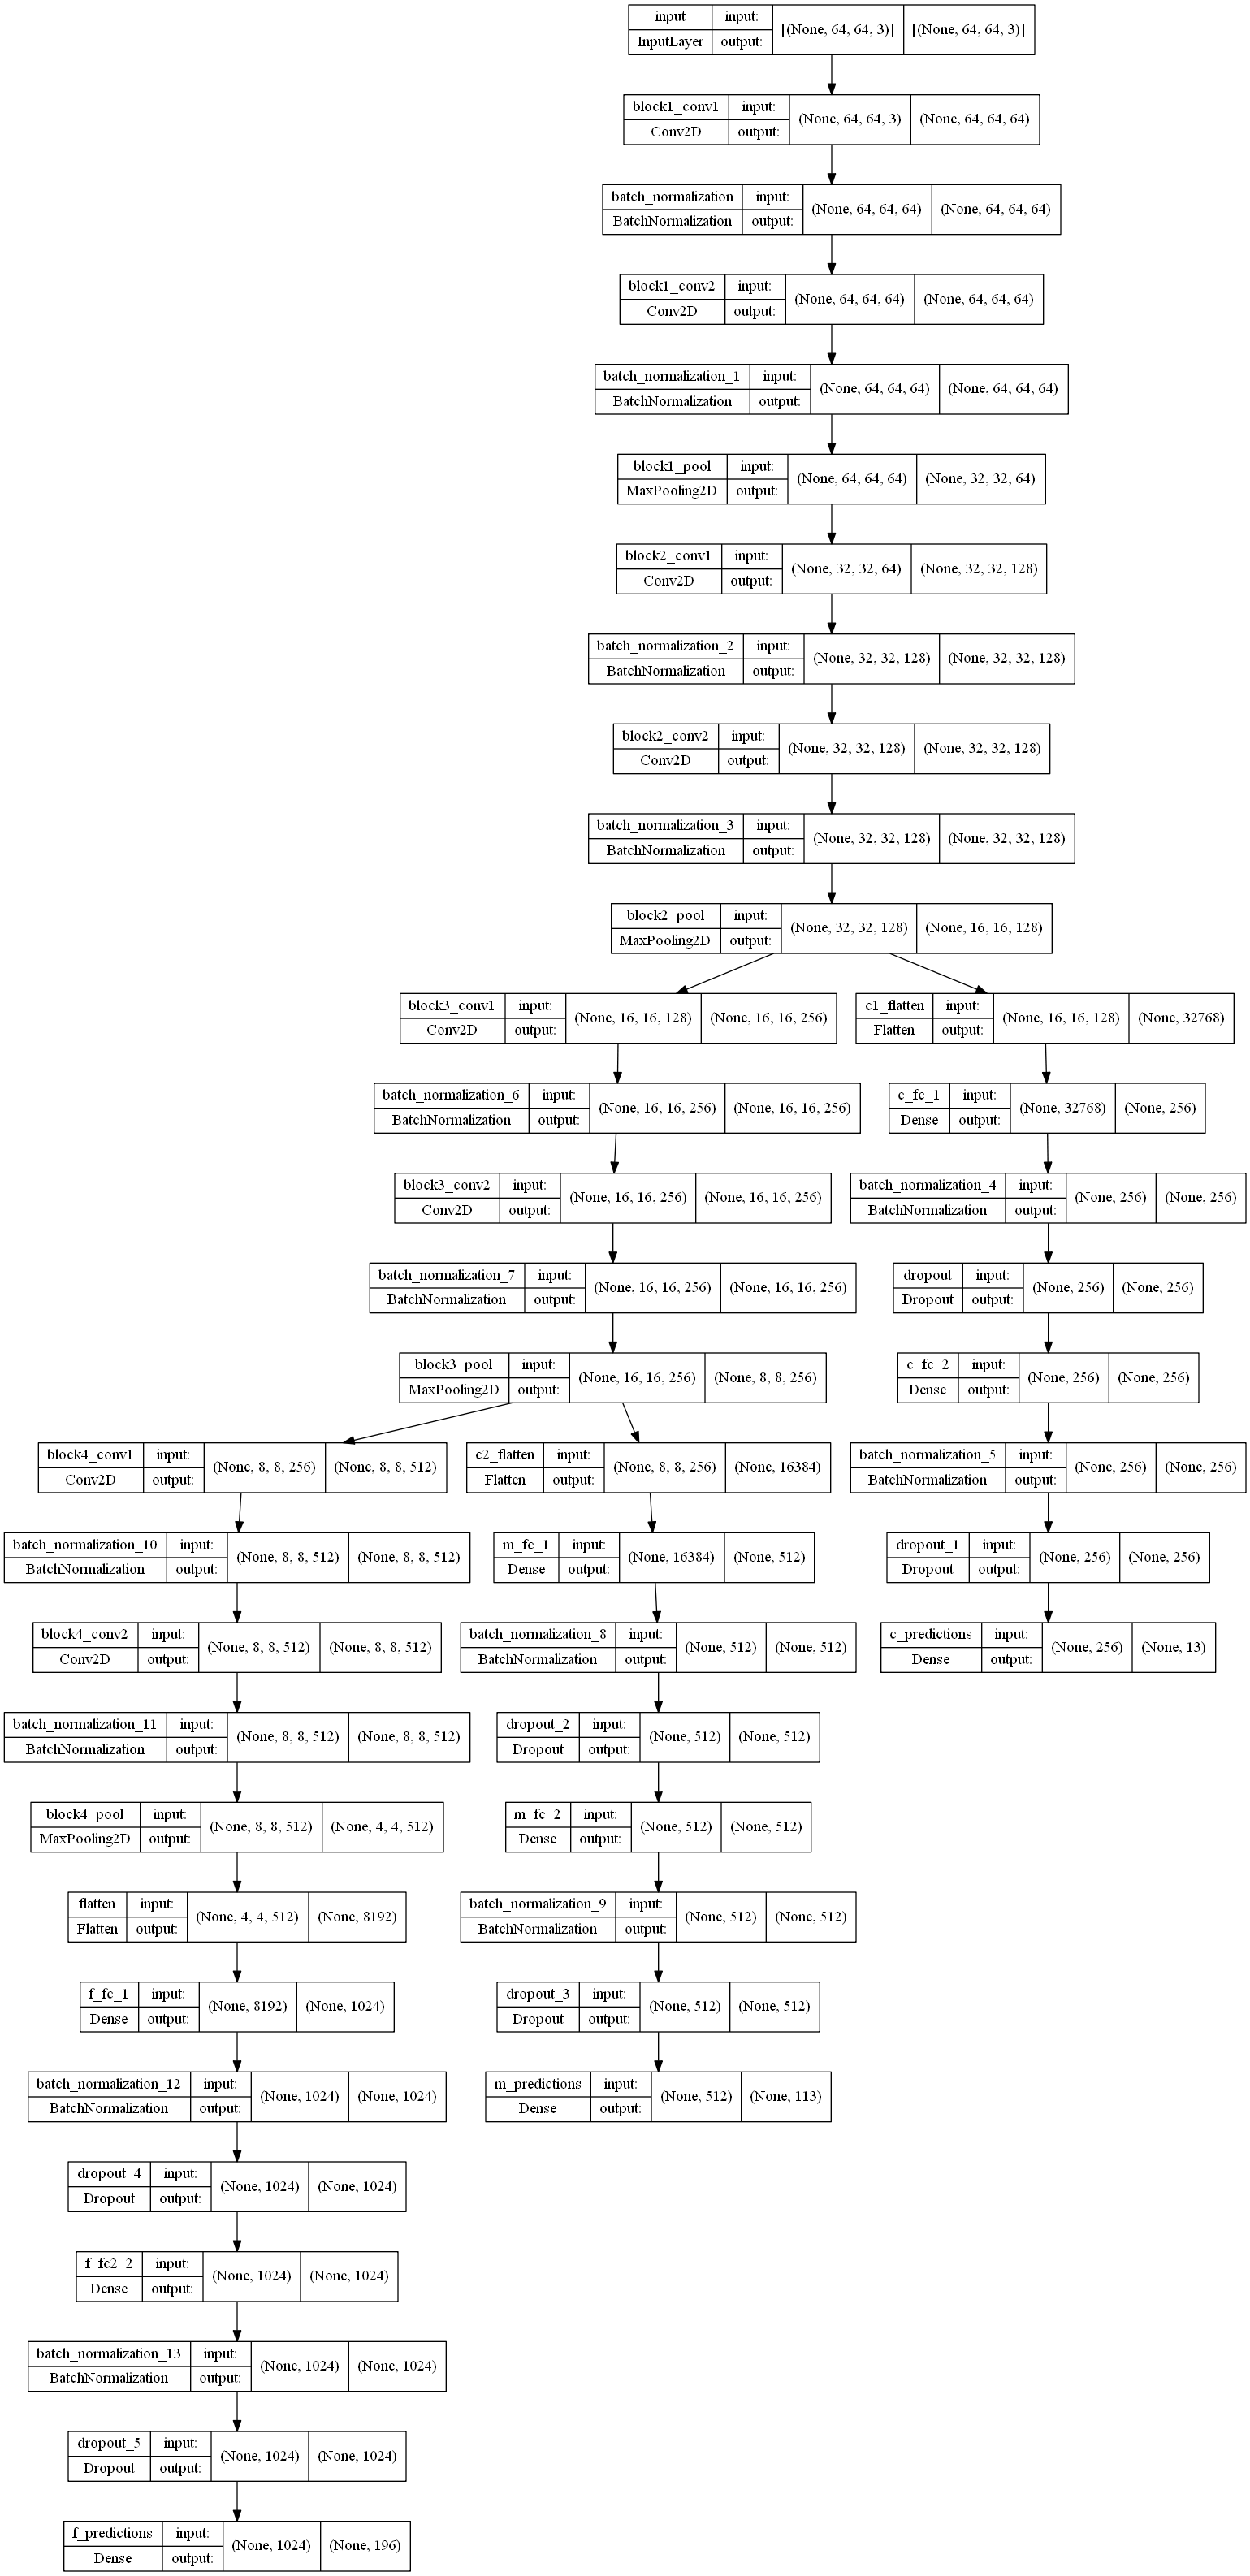

In [9]:
model.summary()
tf.keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

## Loss Weights Modifier

In [10]:
#----------------------- Initial values ---------------------------#
alpha = K.variable(value=0.98, dtype="float32", name="alpha") # A1 in paper
beta = K.variable(value=0.01, dtype="float32", name="beta") # A2 in paper
gamma = K.variable(value=0.01, dtype="float32", name="gamma") # A3 in paper

#----------------------- Update values using CallBacks ---------------------------#
class LossWeightsModifier(keras.callbacks.Callback):
    def __init__(self, alpha, beta, gamma):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 13:
            K.set_value(self.alpha, 0.1)
            K.set_value(self.beta, 0.8)
            K.set_value(self.gamma, 0.1)
        if epoch == 23:
            K.set_value(self.alpha, 0.1)
            K.set_value(self.beta, 0.2)
            K.set_value(self.gamma, 0.7)
        if epoch == 33:
            K.set_value(self.alpha, 0)
            K.set_value(self.beta, 0)
            K.set_value(self.gamma, 1)

## Learning Rate Scheduler

In [11]:
def scheduler(epoch):
    learning_rate_init = 0.001
    if epoch > 55:
        learning_rate_init = 0.0002
    if epoch > 70:
        learning_rate_init = 0.00005
    return learning_rate_init

## Compile Model

In [12]:
model.compile(loss=model_params['loss_function'], 
              optimizer=model_params['optimizer'],
              loss_weights=[alpha, beta, gamma],
              metrics=['accuracy']
             )

# Model Training

# Callbacks

In [13]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)
change_lr = keras.callbacks.LearningRateScheduler(scheduler)
change_lw = LossWeightsModifier(alpha, beta, gamma)
checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch_weights.h5',
                                             monitor='val_f_predictions_accuracy',
                                             save_best_only=True, save_weights_only=True,
                                             verbose=1)
cbks = [tb, log, change_lr, change_lw, checkpoint]

# Training

In [14]:
history = model.fit(training_dataset,
                    epochs = train_params["n_epochs"],
                    validation_data = val_dataset,
                    callbacks = cbks,
                    verbose=1)

model_save_dir = str(directory+'/trained_model.h5')
try:
    model.save_weights(model_save_dir)
    print('Trained model saved to = ', model_save_dir)
except:
    print('Model Wight is not saved')

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 3.6585 - c_predictions_loss: 3.5988 - m_predictions_loss: 6.2518 - f_predictions_loss: 6.9118 - c_predictions_accuracy: 0.1196 - m_predictions_accuracy: 0.0079 - f_predictions_accuracy: 0.0036
Epoch 1: val_f_predictions_accuracy improved from -inf to 0.00522, saving model to ./logs/B_CNN\epoch_weights.h5
64/64 [==============================] - 67s 932ms/step - loss: 3.6585 - c_predictions_loss: 3.5988 - m_predictions_loss: 6.2518 - f_predictions_loss: 6.9118 - c_predictions_accuracy: 0.1196 - m_predictions_accuracy: 0.0079 - f_predictions_accuracy: 0.0036 - val_loss: 2.8509 - val_c_predictions_loss: 2.8058 - val_m_predictions_loss: 4.7773 - val_f_predictions_loss: 5.3495 - val_c_predictions_accuracy: 0.2037 - val_m_predictions_accuracy: 0.0085 - val_f_predictions_accuracy: 0.0052 - lr: 0.0010
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 3.1603 - c_predictions_loss: 3.0907 - m_predictions_loss:

Epoch 11/100
64/64 [==============================] - ETA: 0s - loss: 1.7250 - c_predictions_loss: 1.6286 - m_predictions_loss: 6.1410 - f_predictions_loss: 6.7487 - c_predictions_accuracy: 0.4684 - m_predictions_accuracy: 0.0108 - f_predictions_accuracy: 0.0059
Epoch 11: val_f_predictions_accuracy did not improve from 0.00871
64/64 [==============================] - 57s 892ms/step - loss: 1.7250 - c_predictions_loss: 1.6286 - m_predictions_loss: 6.1410 - f_predictions_loss: 6.7487 - c_predictions_accuracy: 0.4684 - m_predictions_accuracy: 0.0108 - f_predictions_accuracy: 0.0059 - val_loss: 2.1487 - val_c_predictions_loss: 2.0828 - val_m_predictions_loss: 5.0770 - val_f_predictions_loss: 5.6779 - val_c_predictions_accuracy: 0.3465 - val_m_predictions_accuracy: 0.0112 - val_f_predictions_accuracy: 0.0047 - lr: 0.0010
Epoch 12/100
64/64 [==============================] - ETA: 0s - loss: 1.6349 - c_predictions_loss: 1.5371 - m_predictions_loss: 6.1277 - f_predictions_loss: 6.7340 - c_pred

Epoch 21/100
64/64 [==============================] - ETA: 0s - loss: 4.2482 - c_predictions_loss: 1.5676 - m_predictions_loss: 4.3553 - f_predictions_loss: 6.0724 - c_predictions_accuracy: 0.4896 - m_predictions_accuracy: 0.0974 - f_predictions_accuracy: 0.0176
Epoch 21: val_f_predictions_accuracy did not improve from 0.01493
64/64 [==============================] - 58s 901ms/step - loss: 4.2482 - c_predictions_loss: 1.5676 - m_predictions_loss: 4.3553 - f_predictions_loss: 6.0724 - c_predictions_accuracy: 0.4896 - m_predictions_accuracy: 0.0974 - f_predictions_accuracy: 0.0176 - val_loss: 4.2754 - val_c_predictions_loss: 2.0359 - val_m_predictions_loss: 4.4156 - val_f_predictions_loss: 5.3934 - val_c_predictions_accuracy: 0.3557 - val_m_predictions_accuracy: 0.0726 - val_f_predictions_accuracy: 0.0137 - lr: 0.0010
Epoch 22/100
64/64 [==============================] - ETA: 0s - loss: 4.0922 - c_predictions_loss: 1.5372 - m_predictions_loss: 4.1769 - f_predictions_loss: 5.9695 - c_pred

Epoch 31/100
64/64 [==============================] - ETA: 0s - loss: 3.8889 - c_predictions_loss: 1.3455 - m_predictions_loss: 3.5624 - f_predictions_loss: 4.3455 - c_predictions_accuracy: 0.5554 - m_predictions_accuracy: 0.1925 - f_predictions_accuracy: 0.1168
Epoch 31: val_f_predictions_accuracy did not improve from 0.04776
64/64 [==============================] - 58s 914ms/step - loss: 3.8889 - c_predictions_loss: 1.3455 - m_predictions_loss: 3.5624 - f_predictions_loss: 4.3455 - c_predictions_accuracy: 0.5554 - m_predictions_accuracy: 0.1925 - f_predictions_accuracy: 0.1168 - val_loss: 4.5827 - val_c_predictions_loss: 2.0196 - val_m_predictions_loss: 4.3507 - val_f_predictions_loss: 5.0152 - val_c_predictions_accuracy: 0.3632 - val_m_predictions_accuracy: 0.0856 - val_f_predictions_accuracy: 0.0478 - lr: 0.0010
Epoch 32/100
64/64 [==============================] - ETA: 0s - loss: 3.7229 - c_predictions_loss: 1.3238 - m_predictions_loss: 3.4879 - f_predictions_loss: 4.1327 - c_pred

Epoch 41/100
64/64 [==============================] - ETA: 0s - loss: 2.0794 - c_predictions_loss: 1.3110 - m_predictions_loss: 3.4670 - f_predictions_loss: 2.0794 - c_predictions_accuracy: 0.5656 - m_predictions_accuracy: 0.2080 - f_predictions_accuracy: 0.5282
Epoch 41: val_f_predictions_accuracy improved from 0.07388 to 0.07463, saving model to ./logs/B_CNN\epoch_weights.h5
64/64 [==============================] - 56s 882ms/step - loss: 2.0794 - c_predictions_loss: 1.3110 - m_predictions_loss: 3.4670 - f_predictions_loss: 2.0794 - c_predictions_accuracy: 0.5656 - m_predictions_accuracy: 0.2080 - f_predictions_accuracy: 0.5282 - val_loss: 4.7103 - val_c_predictions_loss: 2.0371 - val_m_predictions_loss: 4.2681 - val_f_predictions_loss: 4.7103 - val_c_predictions_accuracy: 0.3368 - val_m_predictions_accuracy: 0.0938 - val_f_predictions_accuracy: 0.0746 - lr: 0.0010
Epoch 42/100
64/64 [==============================] - ETA: 0s - loss: 1.7780 - c_predictions_loss: 1.2983 - m_predictions

Epoch 51/100
64/64 [==============================] - ETA: 0s - loss: 0.4025 - c_predictions_loss: 1.2834 - m_predictions_loss: 3.4521 - f_predictions_loss: 0.4025 - c_predictions_accuracy: 0.5771 - m_predictions_accuracy: 0.2069 - f_predictions_accuracy: 0.9530
Epoch 51: val_f_predictions_accuracy did not improve from 0.08657
64/64 [==============================] - 56s 872ms/step - loss: 0.4025 - c_predictions_loss: 1.2834 - m_predictions_loss: 3.4521 - f_predictions_loss: 0.4025 - c_predictions_accuracy: 0.5771 - m_predictions_accuracy: 0.2069 - f_predictions_accuracy: 0.9530 - val_loss: 4.6932 - val_c_predictions_loss: 2.0290 - val_m_predictions_loss: 4.2565 - val_f_predictions_loss: 4.6932 - val_c_predictions_accuracy: 0.3455 - val_m_predictions_accuracy: 0.0945 - val_f_predictions_accuracy: 0.0818 - lr: 0.0010
Epoch 52/100
64/64 [==============================] - ETA: 0s - loss: 0.3409 - c_predictions_loss: 1.2849 - m_predictions_loss: 3.4792 - f_predictions_loss: 0.3409 - c_pred

Epoch 61/100
64/64 [==============================] - ETA: 0s - loss: 0.1406 - c_predictions_loss: 1.2835 - m_predictions_loss: 3.4452 - f_predictions_loss: 0.1406 - c_predictions_accuracy: 0.5696 - m_predictions_accuracy: 0.2123 - f_predictions_accuracy: 0.9914
Epoch 61: val_f_predictions_accuracy did not improve from 0.09229
64/64 [==============================] - 55s 855ms/step - loss: 0.1406 - c_predictions_loss: 1.2835 - m_predictions_loss: 3.4452 - f_predictions_loss: 0.1406 - c_predictions_accuracy: 0.5696 - m_predictions_accuracy: 0.2123 - f_predictions_accuracy: 0.9914 - val_loss: 4.6581 - val_c_predictions_loss: 2.0084 - val_m_predictions_loss: 4.2499 - val_f_predictions_loss: 4.6581 - val_c_predictions_accuracy: 0.3475 - val_m_predictions_accuracy: 0.0950 - val_f_predictions_accuracy: 0.0883 - lr: 2.0000e-04
Epoch 62/100
64/64 [==============================] - ETA: 0s - loss: 0.1337 - c_predictions_loss: 1.2785 - m_predictions_loss: 3.4442 - f_predictions_loss: 0.1337 - c_

Epoch 71/100
64/64 [==============================] - ETA: 0s - loss: 0.0999 - c_predictions_loss: 1.2810 - m_predictions_loss: 3.4439 - f_predictions_loss: 0.0999 - c_predictions_accuracy: 0.5760 - m_predictions_accuracy: 0.2116 - f_predictions_accuracy: 0.9955
Epoch 71: val_f_predictions_accuracy did not improve from 0.09353
64/64 [==============================] - 58s 910ms/step - loss: 0.0999 - c_predictions_loss: 1.2810 - m_predictions_loss: 3.4439 - f_predictions_loss: 0.0999 - c_predictions_accuracy: 0.5760 - m_predictions_accuracy: 0.2116 - f_predictions_accuracy: 0.9955 - val_loss: 4.6533 - val_c_predictions_loss: 2.0045 - val_m_predictions_loss: 4.2500 - val_f_predictions_loss: 4.6533 - val_c_predictions_accuracy: 0.3500 - val_m_predictions_accuracy: 0.0920 - val_f_predictions_accuracy: 0.0900 - lr: 2.0000e-04
Epoch 72/100
64/64 [==============================] - ETA: 0s - loss: 0.0972 - c_predictions_loss: 1.2529 - m_predictions_loss: 3.4280 - f_predictions_loss: 0.0972 - c_

Epoch 81/100
64/64 [==============================] - ETA: 0s - loss: 0.0877 - c_predictions_loss: 1.2847 - m_predictions_loss: 3.4319 - f_predictions_loss: 0.0877 - c_predictions_accuracy: 0.5685 - m_predictions_accuracy: 0.2097 - f_predictions_accuracy: 0.9959
Epoch 81: val_f_predictions_accuracy did not improve from 0.09378
64/64 [==============================] - 57s 892ms/step - loss: 0.0877 - c_predictions_loss: 1.2847 - m_predictions_loss: 3.4319 - f_predictions_loss: 0.0877 - c_predictions_accuracy: 0.5685 - m_predictions_accuracy: 0.2097 - f_predictions_accuracy: 0.9959 - val_loss: 4.6455 - val_c_predictions_loss: 2.0056 - val_m_predictions_loss: 4.2502 - val_f_predictions_loss: 4.6455 - val_c_predictions_accuracy: 0.3485 - val_m_predictions_accuracy: 0.0913 - val_f_predictions_accuracy: 0.0930 - lr: 5.0000e-05
Epoch 82/100
64/64 [==============================] - ETA: 0s - loss: 0.0903 - c_predictions_loss: 1.2649 - m_predictions_loss: 3.4227 - f_predictions_loss: 0.0903 - c_

Epoch 91/100
64/64 [==============================] - ETA: 0s - loss: 0.0878 - c_predictions_loss: 1.2627 - m_predictions_loss: 3.4241 - f_predictions_loss: 0.0878 - c_predictions_accuracy: 0.5802 - m_predictions_accuracy: 0.2070 - f_predictions_accuracy: 0.9961
Epoch 91: val_f_predictions_accuracy did not improve from 0.09453
64/64 [==============================] - 57s 895ms/step - loss: 0.0878 - c_predictions_loss: 1.2627 - m_predictions_loss: 3.4241 - f_predictions_loss: 0.0878 - c_predictions_accuracy: 0.5802 - m_predictions_accuracy: 0.2070 - f_predictions_accuracy: 0.9961 - val_loss: 4.6439 - val_c_predictions_loss: 2.0063 - val_m_predictions_loss: 4.2508 - val_f_predictions_loss: 4.6439 - val_c_predictions_accuracy: 0.3500 - val_m_predictions_accuracy: 0.0908 - val_f_predictions_accuracy: 0.0933 - lr: 5.0000e-05
Epoch 92/100
64/64 [==============================] - ETA: 0s - loss: 0.0842 - c_predictions_loss: 1.2694 - m_predictions_loss: 3.4255 - f_predictions_loss: 0.0842 - c_

Trained model saved to =  ./logs/B_CNN/trained_model.h5


# Model Analysis

In [15]:
history_dict = history.history

(0.0, 1.0)

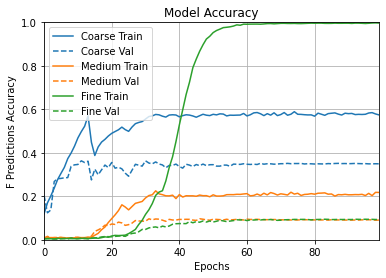

In [16]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "c_predictions_accuracy")
plotter.plot({"Medium": history}, metric = "m_predictions_accuracy")
plotter.plot({"Fine": history}, metric = "f_predictions_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 5.0)

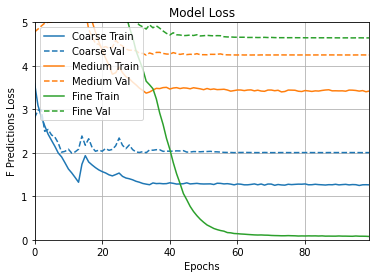

In [17]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "c_predictions_loss")
plotter.plot({"Medium": history}, metric = "m_predictions_loss")
plotter.plot({"Fine": history}, metric = "f_predictions_loss")
plt.title("Model Loss")
plt.ylim([0,5])

In [18]:
results = model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',model.metrics_names[n], '==>', results[n])
model_predictions = model.predict(test_dataset)

32/32 [==============================] - 19s 594ms/step - loss: 4.6426 - c_predictions_loss: 2.0054 - m_predictions_loss: 4.2504 - f_predictions_loss: 4.6426 - c_predictions_accuracy: 0.3494 - m_predictions_accuracy: 0.0905 - f_predictions_accuracy: 0.0938
1. loss ==> 4.642573356628418
2. c_predictions_loss ==> 2.0053937435150146
3. m_predictions_loss ==> 4.250406742095947
4. f_predictions_loss ==> 4.642573356628418
5. c_predictions_accuracy ==> 0.3494155704975128
6. m_predictions_accuracy ==> 0.09052474796772003
7. f_predictions_accuracy ==> 0.09375777095556259


In [19]:
len(model_predictions[0]) == len(model_predictions[1]) == len(model_predictions[2])

True

In [20]:
dataset = {'x_test':[],
           'y_test_coarse':[],
           'y_test_medium':[],
           'y_test_fine':[]}
for x,y in test_dataset.unbatch().as_numpy_iterator():
    dataset['x_test'].append(x)
    dataset['y_test_coarse'].append(y[0])
    dataset['y_test_medium'].append(y[1])
    dataset['y_test_fine'].append(y[2])
    

In [21]:
len(model_predictions[0]) == len(dataset['y_test_coarse'])

True

In [22]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    image = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
                image.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
                image[i] = list(x[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
                image[i] = image[i] + list(x[i].numpy())
    return y_true, y_pred, image

In [23]:
predictions = []
predictions.append(predict_from_pipeline(model, test_dataset))

In [24]:
dataset= {'x_test':predictions[0][2][0], 
          'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [25]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

  • Confusion_Matrix 

  • COARSE LEVEL 
[[107 117   0   0   0  26   0   4   1 182  56   2   0]
 [ 94 183   0   4   0  35   0   1   0 220  60   4   2]
 [  1   2   0   0   0   0   0   0   0   8   2   0   0]
 [  6   8   0  23   0   2   0   2   1  26 102   2   0]
 [  3   8   0  10   1   3   0   0   2  11  52   2   2]
 [ 36  69   0   2   2  24   0   2   1 122  46   1   1]
 [  9   8   0   1   0   2   0   0   0  23   7   0   0]
 [  7  14   0   2   0   5   0   2   0  77  37   5   1]
 [  4   5   0   2   4   2   0   1   3   8  48   2   2]
 [ 94 144   0  14   4  33   0   1   2 587 174   3   2]
 [ 28  48   0  11   1  17   0   1   2 173 425   6   2]
 [  6  13   0   4   1   4   0   2   0  20  41  47   3]
 [ 14  22   0   2   0   6   0   0   0  62  34   1   3]]

  • MEDIUM LEVEL 
[[ 4  2  0 ...  0  0  0]
 [ 0 20  0 ...  0  0  0]
 [ 0  0 11 ...  0  0  0]
 ...
 [ 0  1  1 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]
 [ 0  3  0 ...  0  0  0]]

  • FINE LEVEL 
[[8 0 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 3 1 ... 0

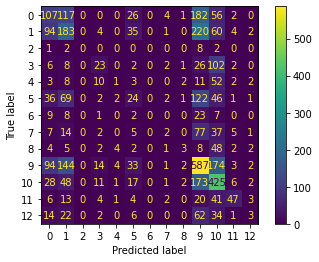

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.26161   0.21616   0.23673       495
           1    0.28549   0.30348   0.29421       603
           2    0.00000   0.00000   0.00000        13
           3    0.30667   0.13372   0.18623       172
           4    0.07692   0.01064   0.01869        94
           5    0.15094   0.07843   0.10323       306
           6    0.00000   0.00000   0.00000        50
           7    0.12500   0.01333   0.02410       150
           8    0.25000   0.03704   0.06452        81
           9    0.38644   0.55482   0.45557      1058
          10    0.39207   0.59524   0.47275       714
          11    0.62667   0.33333   0.43519       141
          12    0.16667   0.02083   0.03704       144

    accuracy                        0.34942      4021
   macro avg    0.23296   0.17669   0.17910      4021
weighted avg    0.31036   0.34942   0.31212      4021


  • MEDIUM LEVEL 


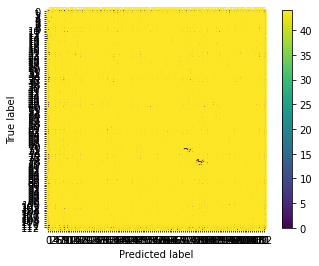

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.15385   0.10811   0.12698        37
           1    0.07407   0.23256   0.11236        86
           2    0.14103   0.28947   0.18966        38
           3    0.15789   0.15789   0.15789        19
           4    0.14286   0.02381   0.04082        42
           5    0.21622   0.19512   0.20513        41
           6    0.12500   0.02174   0.03704        46
           7    0.07282   0.15306   0.09868        98
           8    0.00000   0.00000   0.00000        23
           9    0.10674   0.17925   0.13380       106
          10    0.00000   0.00000   0.00000        19
          11    0.00000   0.00000   0.00000        13
          12    0.00000   0.00000   0.00000        40
          13    0.05172   0.10000   0.06818        60
          14    0.02222   0.01266   0.01613        79
          15    0.13793   0.08511   0.10526        47
          16    0.02778   0.03704   0.03175        54
          17    0.09091   0

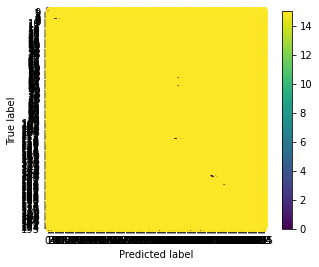

              precision    recall  f1-score   support

           0    0.26667   0.42105   0.32653        19
           1    0.11111   0.05000   0.06897        20
           2    0.01923   0.04762   0.02740        21
           3    0.05263   0.08333   0.06452        24
           4    0.00000   0.00000   0.00000        21
           5    0.13636   0.16667   0.15000        18
           6    0.05714   0.10526   0.07407        19
           7    0.00000   0.00000   0.00000        22
           8    0.00000   0.00000   0.00000        18
           9    0.00000   0.00000   0.00000        20
          10    0.27273   0.65217   0.38462        23
          11    0.00000   0.00000   0.00000        21
          12    0.08696   0.09091   0.08889        22
          13    0.00000   0.00000   0.00000        19
          14    0.16667   0.04762   0.07407        21
          15    0.12500   0.04545   0.06667        22
          16    0.30769   0.20000   0.24242        20
          17    0.00000   0

In [26]:
metrics.lvl_wise_metric(true_label,pred_label)

In [27]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.18173754455773852 
Hierarchical Recall = 0.279615352731493 
Hierarchical F1-Score = 0.21782368754514989 
Consistency =  0.07435961203680676 
Exact Match =  0.016165133051479732
